# EDA + FE - Predicción de ventas estacionales

[Link a la competencia](https://metadata.fundacionsadosky.org.ar/competition/6/)

Análisis exploratorio de datos de los datasets de la competencia.

## Datos de entrada
 * *envios.txt*: datos de los envíos de productos a los POS.
 * *ventas.txt* datos de las ventas en cada POS.
 * *pos.csv*: información demográfica relativa a cada POS.
 

In [1]:
# Ejecuta esta celda para activar tu cuenta de Google Drive.
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

In [2]:
# Imports
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


from IPython.display import display, Markdown as md

# Config
pd.options.display.max_columns = None

## Lectura de datos

Cargamos los archivos de entrada en *DataFrames* de *pandas*.

In [3]:
data_path = "../../data/"

In [4]:
ventas_df = pd.read_csv(os.path.join(data_path, "ventas.txt"), sep="|", parse_dates=["fecha"], dtype={"id_pos": object})
envios_df = pd.read_csv(os.path.join(data_path, "envios.txt"), sep="|", parse_dates=["fecha"], dtype={"id_pos": object})
pos_df = pd.read_csv(os.path.join(data_path, "pos.csv"), sep=",")

In [5]:
#Borrar! Solo para test
# ventas_df = ventas_df.sample(10000, random_state=42)
# envios_df = envios_df.sample(10000, random_state=42)
# pos_df = pos_df.sample(1000, random_state=42)

## Ventas

### EDA

Descripción de las columnas (extraído de la página de la competencia):
*   *fecha*: Fecha de venta.
*   *id_pos*: Identificador único de Punto de Venta.
*   *unidades*: Cantidad de productos vendidos.
*   *canal*: Es la clase de tienda en la que se realizó la venta.

In [6]:
display("Dimensiones del DataFrame: {}".format(ventas_df.shape))
display(ventas_df.head())

'Dimensiones del DataFrame: (266436, 4)'

,fecha,id_pos,unidades,canal
0,2012-10-01,8495,4,MAXIKIOSCO
1,2012-10-10,8571,1,MAXIKIOSCO
2,2012-10-11,8915,1,MAXIKIOSCO
3,2012-10-12,8915,3,MAXIKIOSCO
4,2012-10-13,8923,1,MAXIKIOSCO


In [7]:
display(ventas_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266436 entries, 0 to 266435
Data columns (total 4 columns):
fecha       266436 non-null datetime64[ns]
id_pos      266436 non-null object
unidades    266436 non-null int64
canal       266436 non-null object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 8.1+ MB


None

*   No tiene nulos
*   La fecha se leyó correctamente como *datetime*
*   Las columna *unidades* tiene valores enteros
*   La columna *canal* tiene texto (*object*)

In [8]:
display(ventas_df.describe(include="all"))

,fecha,id_pos,unidades,canal
count,266436,266436,266436.000000,266436
unique,276,12302,NaN,4
top,2013-12-24 00:00:00,4369,NaN,ALMACEN
freq,9726,98,NaN,265207
first,2012-10-01 00:00:00,NaN,NaN,NaN
last,2014-11-30 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,2.378481,NaN
std,NaN,NaN,2.391836,NaN
min,NaN,NaN,-29.000000,NaN
25%,NaN,NaN,1.000000,NaN


*   Las fechas van desde el 01/10/2012 hasta el 30/11/2014 (las predicciones hay que hacerlas a partir del 01/12/2014)
*   *id_pos* tiene 12302 valores distintos (12302 puntos de venta!)
*   *unidades* tiene al menos un valor negativo
*   *canal* tiene 4 valores distintos



In [9]:
print("Tipos de canales: {}".format(ventas_df["canal"].unique().tolist()))

Tipos de canales: ['MAXIKIOSCO', 'ALMACEN', 'SUPERMERCADOS', 'PARTICULARES']


In [10]:
print("Ventas por tipo de canal:")
print(ventas_df.loc[:, ["canal", "unidades"]].groupby(by="canal").sum())

Ventas por tipo de canal:
               unidades
canal                  
ALMACEN          631814
MAXIKIOSCO         1844
PARTICULARES         26
SUPERMERCADOS        29


Veamos la distribución de cuántas unidades venden los POS.

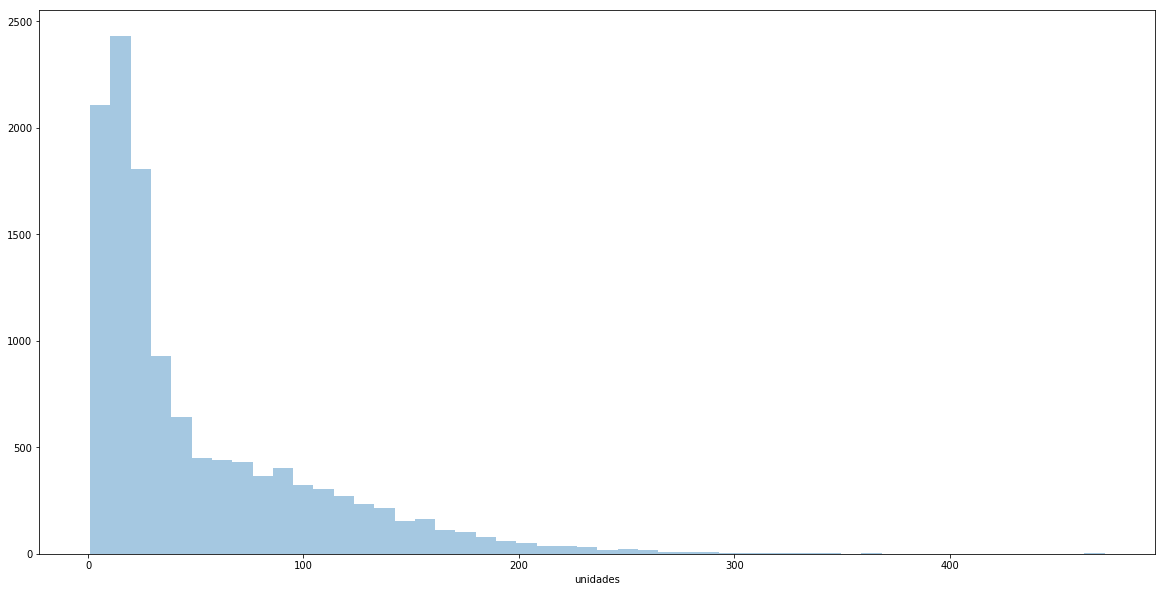

In [11]:
plt.figure(figsize=(20, 10));
sns.distplot(ventas_df.loc[:, ["id_pos", "unidades"]].groupby(by="id_pos").sum()["unidades"], kde=False, rug=False)

*   La gran mayoría de los POS (entre 2012, 2013 y 2014) vendieron menos de 50 unidades
*   Muy pocos POS vendieron más de 200 unidades.

### Fechas
A partir del atributo *fecha* vamos a crear nuevos atributos derivados:
*   *fecha_dia*: día del mes (número entero del 1 al 31)
*   *fecha_mes*: mes del año (número entero del 1 al 12)
*   *fecha_anio*: año (número entero)
*   *fecha_dia_de_semana*: día de la semana (lunes, martes, ...)
*   *fecha_fin_de_semana*: booleana que indica si es fin de semana (sábado o domingo)

In [12]:
dias_semana =  {0: "lunes", 1: "martes", 2: "miercoles", 3: "jueves", 4: "viernes", 5: "sabado", 6: "domingo"}

ventas_df.loc[:, "fecha_dia"] = ventas_df["fecha"].dt.day
ventas_df.loc[:, "fecha_mes"] = ventas_df["fecha"].dt.month
ventas_df.loc[:, "fecha_anio"] = ventas_df["fecha"].dt.year
ventas_df.loc[:, "fecha_dia_de_semana"] = ventas_df["fecha"].dt.weekday.map(dias_semana)
ventas_df.loc[:, "fecha_fin_de_semana"] = ventas_df["fecha"].dt.weekday >= 5
  
display(ventas_df.head())

,fecha,id_pos,unidades,canal,fecha_dia,fecha_mes,fecha_anio,fecha_dia_de_semana,fecha_fin_de_semana
0,2012-10-01,8495,4,MAXIKIOSCO,1,10,2012,lunes,False
1,2012-10-10,8571,1,MAXIKIOSCO,10,10,2012,miercoles,False
2,2012-10-11,8915,1,MAXIKIOSCO,11,10,2012,jueves,False
3,2012-10-12,8915,3,MAXIKIOSCO,12,10,2012,viernes,False
4,2012-10-13,8923,1,MAXIKIOSCO,13,10,2012,sabado,True


Vamos a graficar la distribución de las variables *fecha_dia_semana*, *fecha_dia* y *fecha_mes* para ver si podemos sacar alguna conclusión.

<Figure size 1440x1800 with 0 Axes>

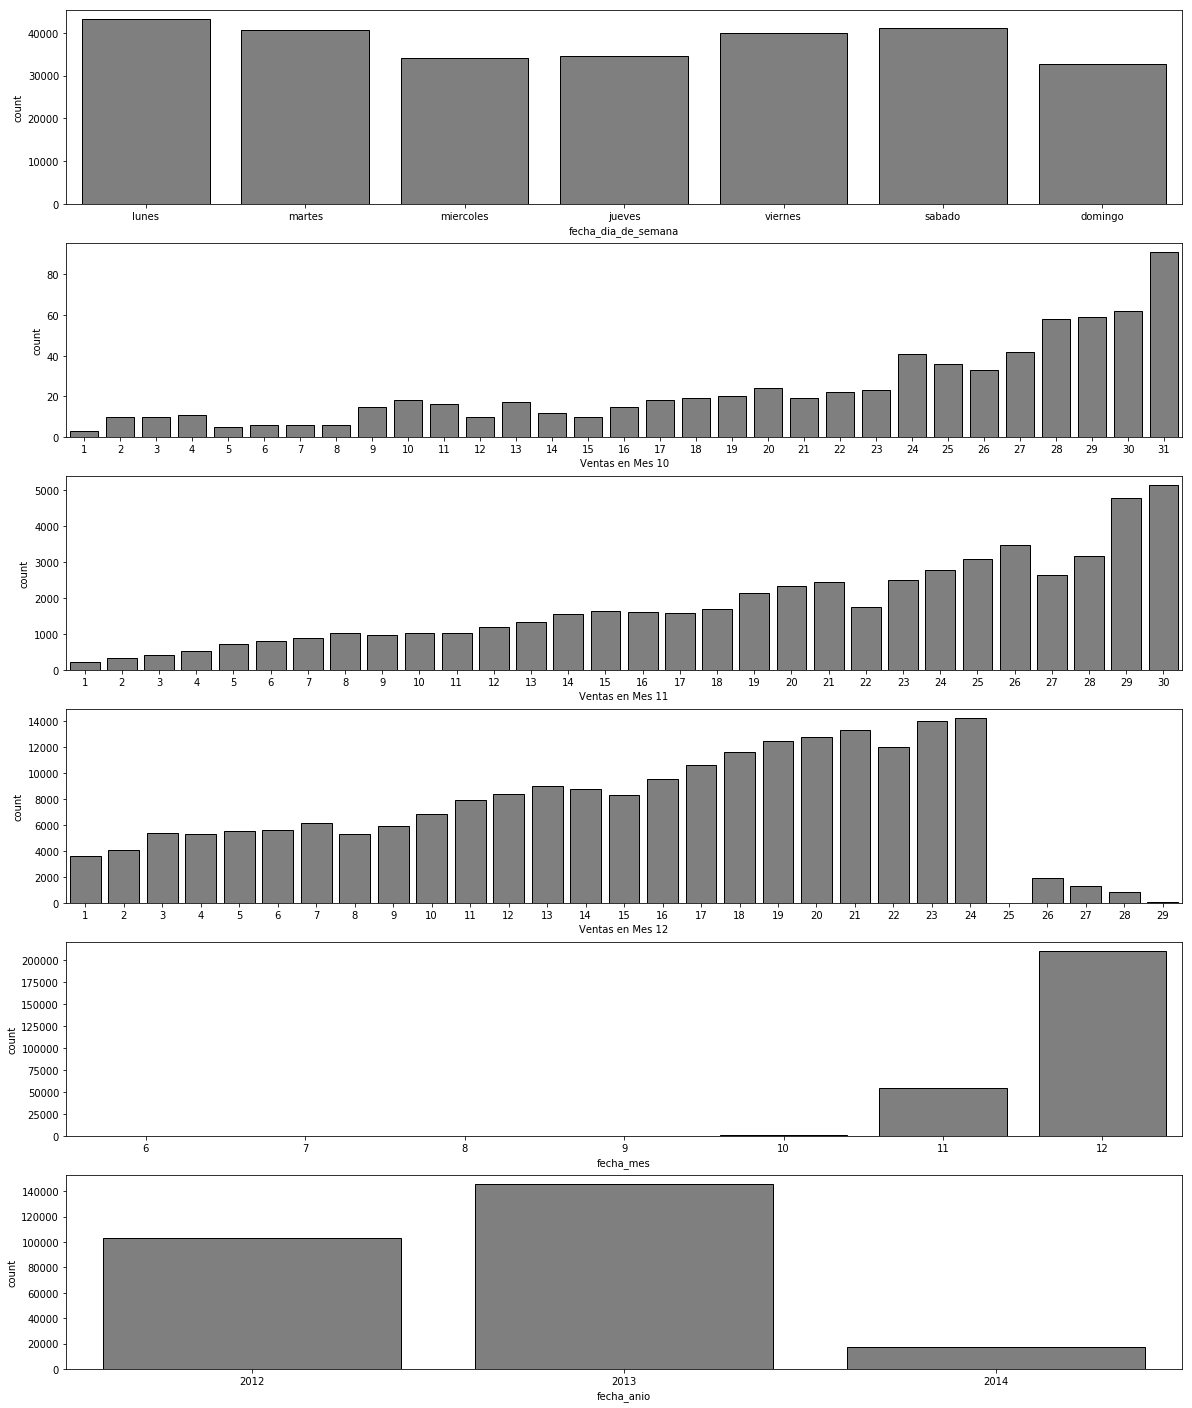

In [13]:
fig = plt.figure(figsize=(20,25))

fig, axs = plt.subplots(6, 1, figsize=(20, 25))
axs = axs.ravel()

sns.countplot(ventas_df["fecha_dia_de_semana"], facecolor=(0,0,0,0.5), edgecolor="black", order=["lunes", "martes", "miercoles",
                                                                                                 "jueves", "viernes", "sabado",
                                                                                                 "domingo"], 
              ax=axs[0])
sns.countplot(ventas_df.loc[ventas_df["fecha_mes"] == 10, "fecha_dia"], facecolor=(0,0,0,0.5), edgecolor="black", ax=axs[1])
sns.countplot(ventas_df.loc[ventas_df["fecha_mes"] == 11, "fecha_dia"], facecolor=(0,0,0,0.5), edgecolor="black", ax=axs[2])
sns.countplot(ventas_df.loc[ventas_df["fecha_mes"] == 12, "fecha_dia"], facecolor=(0,0,0,0.5), edgecolor="black", ax=axs[3])
sns.countplot(ventas_df["fecha_mes"], facecolor=(0,0,0,0.5), edgecolor="black", ax=axs[4])
sns.countplot(ventas_df["fecha_anio"], facecolor=(0,0,0,0.5), edgecolor="black", ax=axs[5])

axs[1].set(xlabel="Ventas en Mes 10")
axs[2].set(xlabel="Ventas en Mes 11")
axs[3].set(xlabel="Ventas en Mes 12")

plt.show()

*   Las ventas se distribuyen (casi) equitativamente entre todos los días de la semana. Los miércoles, jueves y domingos se vende un poco menos
*   Da la impresión que las ventas aumentan a diario linealmente hasta el 25/12 (Navidad). A partir de ese día, disminuyen considerablemente.
*   Se vende la gran parte en los meses 11 (noviembre) y 12 (diciembre)
*   En el 2013 se vendió considerablemente más que en el 2012. El 2014 no incluye diciembre, por lo cual no podemos compararlo

Considerando que los datos pertenecen al último trimestre de cada año, y que se ve una relación directa entre el día del trimestre y la cantidad de unidades vendidas, parece razonable hacer un nuevo atirbuto *dia_trimestre* con un entero entre 1 (día 1 del mes 10) y 92 (día 31 del mes 12). 

In [14]:
def __get_dia_trimestre(row):
    """ Devuelve el número de día del trimestre para 'row' """
    if row["fecha_mes"] == 10: # Octubre
        return row["fecha_dia"]
    elif row["fecha_mes"] == 11: # Noviembre
        return 31 + row["fecha_dia"]
    else: # Diciembre
        return 31 + 30 + row["fecha_dia"]

ventas_df["fecha_dia_trimestre"] = ventas_df.apply(__get_dia_trimestre, axis=1)

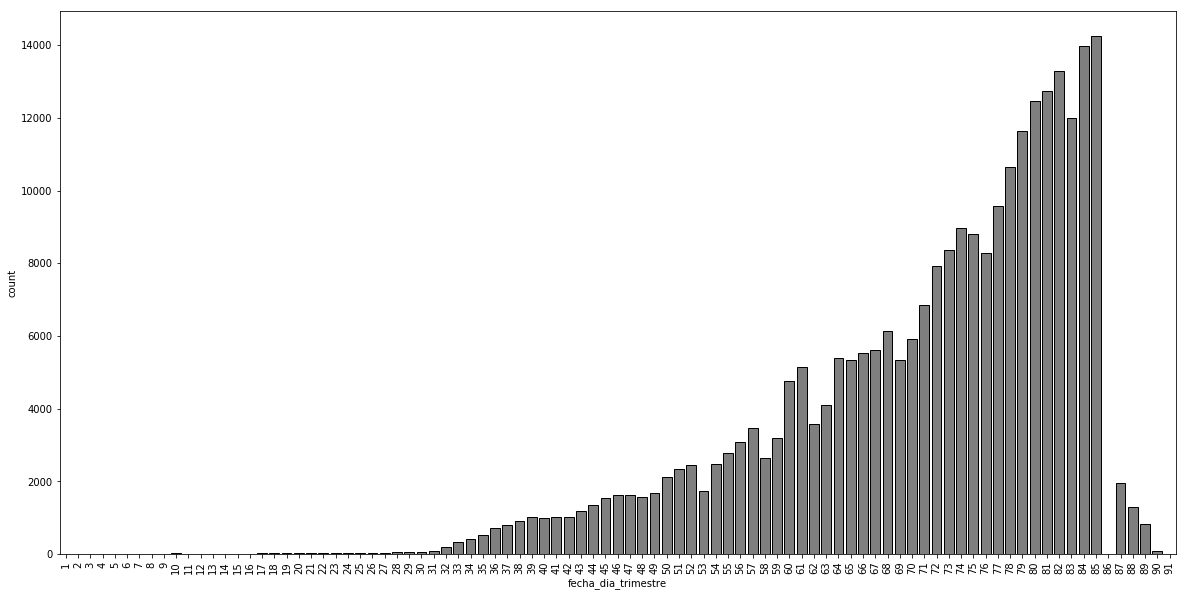

In [15]:
plt.figure(figsize=(20, 10));
g = sns.countplot(ventas_df["fecha_dia_trimestre"], facecolor=(0,0,0,0.5), edgecolor="black");
plt.xticks(rotation=90);

*   Efectivamente, las ventas crecen día a día en el último trimestre del año, hasta el 25 de Diciembre

### Ventas previas
Considerando que las ventas previas pueden ayudar a estimar las ventas futuras de cada POS, vamos a calcular los siguientes atributos:
*   *total_ventas_[MES]_[ANIO]*: cantidad de unidades vendidas por el POS en cada mes y año

In [16]:
ventas_df.set_index(["id_pos", "fecha_anio", "fecha_mes", "fecha_dia"], inplace=True);
ventas_df.sort_index();

In [17]:
mes_anio_list = [(10, 2012), (11, 2012), (12, 2012), 
                 (10, 2013), (11, 2013), (12, 2013), 
                 (10, 2014), (11, 2014)]

def get_ventas_mes_anio(id_pos, anio, mes):
    """ Devuelve la cantidad de unidades vendidas por 'id_pos' en 'mes'/'anio' """   
    subset_df = ventas_df.xs((id_pos, anio, mes), level=["id_pos", "fecha_anio", "fecha_mes"])

    if subset_df.empty is False:
        return subset_df["unidades"].sum()
    else:
        return 0
    
for i, id_pos in enumerate(ventas_df.index.unique(level='id_pos')):
    if i % 1000 == 0:
        print("Procesando {}".format(i))
    for mes, anio in mes_anio_list:
        col = "total_ventas_{0}_{1}".format(mes, anio)
        ventas_df.loc[id_pos, col] = get_ventas_mes_anio(id_pos, anio, mes)
  

Procesando 0


c:\users\matias\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


Procesando 1000
Procesando 2000
Procesando 3000
Procesando 4000
Procesando 5000
Procesando 6000
Procesando 7000
Procesando 8000
Procesando 9000
Procesando 10000
Procesando 11000
Procesando 12000


In [18]:
ventas_df.reset_index(inplace=True)
display(ventas_df.head())

,id_pos,fecha_anio,fecha_mes,fecha_dia,fecha,unidades,canal,fecha_dia_de_semana,fecha_fin_de_semana,fecha_dia_trimestre,total_ventas_10_2012,total_ventas_11_2012,total_ventas_12_2012,total_ventas_10_2013,total_ventas_11_2013,total_ventas_12_2013,total_ventas_10_2014,total_ventas_11_2014
0,8495,2012,10,1,2012-10-01,4,MAXIKIOSCO,lunes,False,1,4.0,1.0,19.0,0.0,0.0,0.0,0.0,0.0
1,8571,2012,10,10,2012-10-10,1,MAXIKIOSCO,miercoles,False,10,1.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0
2,8915,2012,10,11,2012-10-11,1,MAXIKIOSCO,jueves,False,11,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8915,2012,10,12,2012-10-12,3,MAXIKIOSCO,viernes,False,12,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8923,2012,10,13,2012-10-13,1,MAXIKIOSCO,sabado,True,13,2.0,6.0,5.0,0.0,1.0,5.0,0.0,0.0


### Codificación dummy
Codificación *dummy* para las variables categóricas en *ventas_df*

In [19]:
categorical_columns = ["canal", "fecha_dia_de_semana"]

for col in categorical_columns:
    ventas_df = pd.concat([ventas_df, pd.get_dummies(ventas_df[col], prefix=col)], axis=1)

ventas_df.drop(columns=categorical_columns, errors="ignore", inplace=True)

display(ventas_df.head())

,id_pos,fecha_anio,fecha_mes,fecha_dia,fecha,unidades,fecha_fin_de_semana,fecha_dia_trimestre,total_ventas_10_2012,total_ventas_11_2012,total_ventas_12_2012,total_ventas_10_2013,total_ventas_11_2013,total_ventas_12_2013,total_ventas_10_2014,total_ventas_11_2014,canal_ALMACEN,canal_MAXIKIOSCO,canal_PARTICULARES,canal_SUPERMERCADOS,fecha_dia_de_semana_domingo,fecha_dia_de_semana_jueves,fecha_dia_de_semana_lunes,fecha_dia_de_semana_martes,fecha_dia_de_semana_miercoles,fecha_dia_de_semana_sabado,fecha_dia_de_semana_viernes
0,8495,2012,10,1,2012-10-01,4,False,1,4.0,1.0,19.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,1,0,0,0,0
1,8571,2012,10,10,2012-10-10,1,False,10,1.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0
2,8915,2012,10,11,2012-10-11,1,False,11,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,0,0,0
3,8915,2012,10,12,2012-10-12,3,False,12,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,1
4,8923,2012,10,13,2012-10-13,1,True,13,2.0,6.0,5.0,0.0,1.0,5.0,0.0,0.0,0,1,0,0,0,0,0,0,0,1,0


## Envíos


### EDA
Descripción de las columnas (extraído de la página de la competencia):
*   *fecha*: Fecha de envío.
*   *id_pos*: Identificador único de Punto de Venta.
*   *unidades_despachadas*: Cantidad de productos enviados al POS en la fecha mencionada.
*   *cantidad_envios*: Cantidad de envíos realizados para la fecha y POS en cuestión.

In [20]:
display("Dimensiones del DataFrame: {}".format(envios_df.shape))
display(envios_df.head())

'Dimensiones del DataFrame: (42434, 4)'

,fecha,id_pos,unidades_despachadas,cantidad_envios
0,2012-08-17,5235,36,1
1,2012-08-24,4611,48,1
2,2012-08-24,4645,48,1
3,2012-08-24,4649,72,1
4,2012-08-24,4677,72,1


In [21]:
display(envios_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42434 entries, 0 to 42433
Data columns (total 4 columns):
fecha                   42434 non-null datetime64[ns]
id_pos                  42434 non-null object
unidades_despachadas    42434 non-null int64
cantidad_envios         42434 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.3+ MB


None

*   No tiene nulos
*   La fecha se leyó correctamente como *datetime*
*   Las *unidades_despachadas* y *cantidad_envios* son enteros

In [22]:
display(envios_df.describe(include="all"))

,fecha,id_pos,unidades_despachadas,cantidad_envios
count,42434,42434,42434.000000,42434.000000
unique,41,13449,NaN,NaN
top,2012-10-19 00:00:00,3566,NaN,NaN
freq,9452,10,NaN,NaN
first,2012-08-17 00:00:00,NaN,NaN,NaN
last,2014-11-29 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,35.532827,1.000165
std,NaN,NaN,32.258875,0.012843
min,NaN,NaN,12.000000,1.000000
25%,NaN,NaN,12.000000,1.000000


*   Las fechas están en el mismo rango que en *ventas_df*
*   En este caso hay más valores de *id_pos* (13449). Esto quiere decir que hay 1147 POS que recibieron productos, pero que no registraron ninguna venta
*   La mayoría de los POS recibió solamente un envío. El máximo de envíos recibidos por un POS es 2

### Fechas

Al igual que hicimos con *ventas_df*, creamos nuevos atributos a partir de *fecha*.

In [23]:
envios_df.loc[:, "fecha_dia"] = envios_df["fecha"].dt.day
envios_df.loc[:, "fecha_mes"] = envios_df["fecha"].dt.month
envios_df.loc[:, "fecha_anio"] = envios_df["fecha"].dt.year
envios_df.loc[:, "fecha_dia_de_semana"] = envios_df["fecha"].dt.weekday.map(dias_semana)
envios_df.loc[:, "fecha_fin_de_semana"] = envios_df["fecha"].dt.weekday >= 5
  
display(envios_df.head())

,fecha,id_pos,unidades_despachadas,cantidad_envios,fecha_dia,fecha_mes,fecha_anio,fecha_dia_de_semana,fecha_fin_de_semana
0,2012-08-17,5235,36,1,17,8,2012,viernes,False
1,2012-08-24,4611,48,1,24,8,2012,viernes,False
2,2012-08-24,4645,48,1,24,8,2012,viernes,False
3,2012-08-24,4649,72,1,24,8,2012,viernes,False
4,2012-08-24,4677,72,1,24,8,2012,viernes,False


Al igual que hicimos con las ventas, veamos las distribuciones de los envíos con respecto a las fechas.

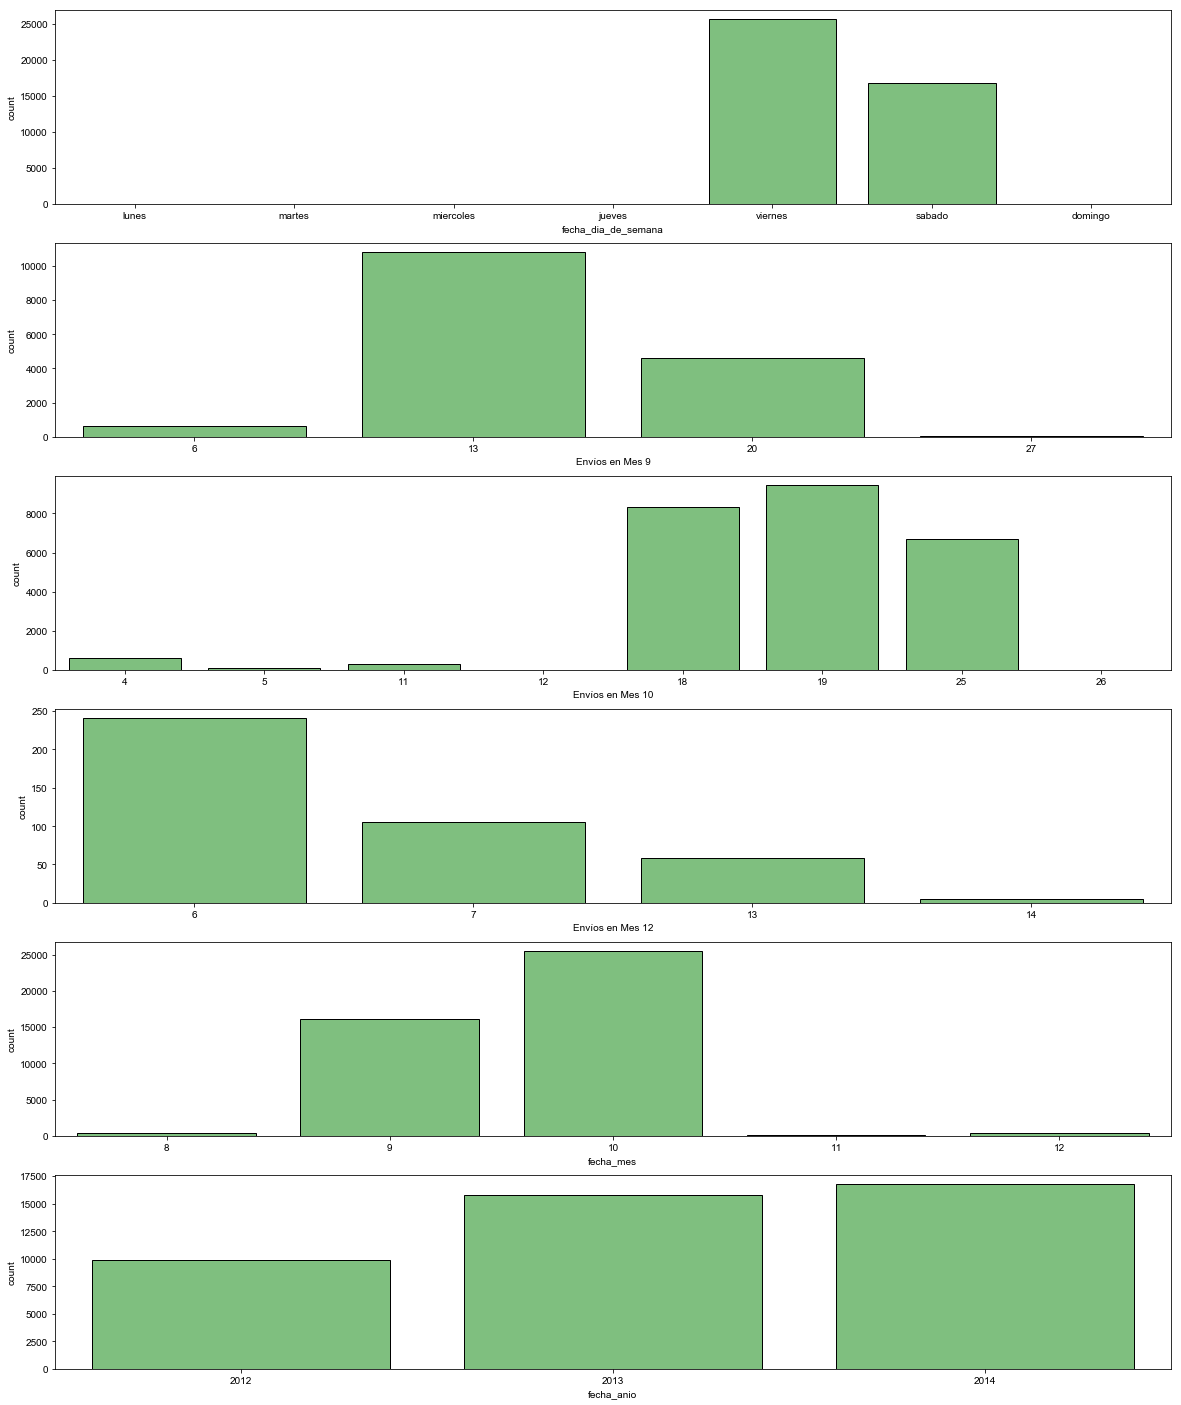

In [24]:
fig = plt.figure(figsize=(20,25))

ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)
ax4 = fig.add_subplot(614)
ax5 = fig.add_subplot(615)
ax6 = fig.add_subplot(616)

sns.countplot(envios_df["fecha_dia_de_semana"], facecolor=(0,0.5,0,0.5), edgecolor="black", order=["lunes", "martes", "miercoles", "jueves", "viernes", "sabado", "domingo"], ax=ax1)
sns.countplot(envios_df.loc[envios_df["fecha_mes"] == 9, "fecha_dia"], facecolor=(0,0.5,0,0.5), edgecolor="black", ax=ax2)
sns.countplot(envios_df.loc[envios_df["fecha_mes"] == 10, "fecha_dia"], facecolor=(0,0.5,0,0.5), edgecolor="black", ax=ax3)
sns.countplot(envios_df.loc[envios_df["fecha_mes"] == 12, "fecha_dia"], facecolor=(0,0.5,0,0.5), edgecolor="black", ax=ax4)
sns.countplot(envios_df["fecha_mes"], facecolor=(0,0.5,0,0.5), edgecolor="black", ax=ax5)
sns.countplot(envios_df["fecha_anio"], facecolor=(0,0.5,0,0.5), edgecolor="black", ax=ax6)

ax2.set(xlabel="Envíos en Mes 9")
ax3.set(xlabel="Envíos en Mes 10")
ax4.set(xlabel="Envíos en Mes 12")

sns.set();
plt.show()

*   Los envíos se hacen los viernes y sábados
*   En los gráficos de los envíos en cada día del mes, se puede ver que los envíos se hacen cada 6/7 días.
*   La gran parte de los envíos son en los meses 9 (septiembre) y 10 (octubre)
*   Los envíos se incrementaron año tras año

## POS

### EDA

Descripción de las columnas (extraído de la página de la competencia):
*   *id_pos*: Identificador único de Punto de Venta.
*   *competidores*: Número de competidores en un radio de una milla del POS.
*   *ingreso_mediana*: Mediana del ingreso para el código postal en cuestión
*   *ingreso_promedio*: Ingreso promedio para el código postal en cuestión.
*   *densidad_poblacional*: Densidad poblacional para el código postal en cuestión.
*   *pct_0a5*: Porcentaje de la población de 0 a 5 años.
*   *pct_5a9*: Porcentaje de la población de 5 a 9 años.
*   *pct_10a14*: Porcentaje de la población de 10 a 14 años.
*   *pct_15a19*: Porcentaje de la población de 15 a 19 años.
*   *pct_20a24*: Porcentaje de la población de 20 a 24 años.
*   *pct_25a29*: Porcentaje de la población de 25 a 29 años.
*   *pct_30a34*: Porcentaje de la población de 30 a 34 años.
*   *pct_35a39*: Porcentaje de la población de 35 a 39 años.
*   *pct_40a44*: Porcentaje de la población de 40 a 44 años.
*   *pct_45a49*: Porcentaje de la población de 45 a 49 años.
*   *pct_50a54*: Porcentaje de la población de 50 a 54 años.
*   *pct_55a59*: Porcentaje de la población de 55 a 59 años.
*   *pct_60a64*: Porcentaje de la población de 60 a 64 años.
*   *pct_65a69*: Porcentaje de la población de 65 a 69 años.
*   *pct_70a74*: Porcentaje de la población de 70 a 74 años.
*   *pct_75a79*: Porcentaje de la población de 75 a 79 años.
*   *pct_80a84*: Porcentaje de la población de 80 a 84 años.
*   *pct_85ainf*: Porcentaje de la población mayor a 85 años.
*   *pct_bachelors*: Porcentaje de la población con título de bachelor.
*   *pct_doctorados*: Porcentaje de la población con título de doctor.
*   *pct_secundario*: Porcentaje de la población con título secundario.
*   *pct_master*: Porcentaje de la población con título de master.
*   *pct_bicicleta*: Porcentaje de utilización de bicicletas.
*   *pct_omnibus*: Porcentaje de utilización de omnibus.
*   *pct_subtes*: Porcentaje de utilización de subtes.
*   *pct_taxi*: Porcentaje de utilización de taxis.
*   *pct_caminata*: Porcentaje de transporte de a pie.
*   *mediana_valor_hogar*: Mediana de valor del hogar en la vecindad del POS.

In [25]:
display("Dimensiones del DataFrame: {}".format(pos_df.shape))
display(pos_df.head())

'Dimensiones del DataFrame: (13375, 33)'

,id_pos,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_0a5,pct_5a9,pct_10a14,pct_15a19,pct_20a24,pct_25a29,pct_30a34,pct_35a39,pct_40a44,pct_45a49,pct_50a54,pct_55a59,pct_60a64,pct_65a69,pct_70a74,pct_75a79,pct_80a84,pct_85ainf,pct_bachelors,pct_doctorados,pct_secundario,pct_master,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar
0,-37,9.0,60769.03000,84420.06500,32715.700,5.260000,4.33000,4.245000,4.71000,5.935000,11.185000,9.74000,7.605000,6.465000,5.670000,6.445000,6.470000,6.240000,4.905000,4.080000,2.565000,2.065000,2.095000,22.880000,2.395000,21.44000,10.60,1.935000,3.055000,26.00500,1.360000,16.475000,434685.4150
1,-37,6.0,39675.89000,50716.23000,29985.710,8.860000,8.60000,8.170000,7.58000,8.950000,8.230000,7.23000,6.050000,5.950000,5.520000,5.610000,5.250000,4.590000,3.680000,2.270000,1.480000,1.100000,0.890000,10.610000,0.230000,25.97000,2.51,0.550000,2.910000,0.47000,0.000000,1.380000,143807.1500
2,-37,36.0,65351.97750,82575.15000,7610.355,6.460000,6.29625,6.088750,5.75875,7.031250,7.755000,7.39125,6.462500,6.710000,6.803750,7.126250,6.430000,5.192500,4.120000,3.258750,2.490000,2.122500,2.507500,20.667500,1.328750,29.25625,8.87,0.257500,0.742500,0.17125,0.013750,2.360000,212977.4850
3,-37,25.0,62489.12167,84227.44333,5685.860,6.288333,7.19000,6.958333,6.15000,5.841667,6.311667,6.68500,6.256667,6.548333,5.758333,6.621667,6.911667,6.373333,4.978333,3.686667,2.701667,2.093333,2.643333,25.001667,1.513333,22.80500,8.90,0.221667,1.056667,0.00500,0.266667,2.091667,219048.1067
4,-37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*   *id_pos* con valores negativos. **REVISAR**

Para simplificar el análisis y procesamiento del dataset, vamos a agrupar algunas columnas:

*  *pct_ninios*: Suma los porcentajes de *pct_0a5*, *pct_5a9*, *pct_10a14*
*  *pct_jovenes*: Suma los porcentajes de *pct_15a19*, *pct_20a24*, *pct_25a29*
*  *pct_adultos*: Suma los porcentajes de *pct_30a34*, *pct_30a34*, *pct_35a39*, *pct_40a44*, *pct_45a49*, *pct_50a54*, *pct_55a59*, *pct_60a64*, *pct_65a69*
*  *pct_ancianos*: Suma los porcentajes de *pct_70a74*, *pct_75a79*, *pct_80a84*, *pct_85ainf*
*  *pct_posgrados*: Suma los porcentajes de *pct_bachelors*,  *pct_doctorados*, *pct_master*



In [26]:
merge_cols = [("pct_ninios", ["pct_0a5", "pct_5a9", "pct_10a14"]), 
             ("pct_jovenes", ["pct_15a19", "pct_20a24", "pct_25a29"]),
             ("pct_adultos", ["pct_30a34", "pct_30a34", "pct_35a39", 
                              "pct_40a44", "pct_45a49", "pct_50a54", 
                              "pct_55a59", "pct_60a64", "pct_65a69"]),
             ("pct_ancianos", ["pct_70a74", "pct_75a79", "pct_80a84", 
                               "pct_85ainf"]),
             ("pct_posgrados", ["pct_bachelors", "pct_doctorados", "pct_master"]
             )]

for result_col, cols in merge_cols:
    pos_df[result_col] = pos_df.loc[:, cols].sum(axis=1)
    pos_df.drop(columns=cols, inplace=True, errors="ignore")

In [27]:
display(pos_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13375 entries, 0 to 13374
Data columns (total 17 columns):
id_pos                  13265 non-null object
competidores            13228 non-null float64
ingreso_mediana         13255 non-null float64
ingreso_promedio        13255 non-null float64
densidad_poblacional    13254 non-null float64
pct_secundario          13254 non-null float64
pct_bicicleta           13254 non-null float64
pct_omnibus             13254 non-null float64
pct_subtes              13254 non-null float64
pct_taxi                13254 non-null float64
pct_caminata            13254 non-null float64
mediana_valor_hogar     13256 non-null float64
pct_ninios              13375 non-null float64
pct_jovenes             13375 non-null float64
pct_adultos             13375 non-null float64
pct_ancianos            13375 non-null float64
pct_posgrados           13375 non-null float64
dtypes: float64(16), object(1)
memory usage: 1.7+ MB


None

*   Todas las columnas tienen valores nulos

In [28]:
display(pos_df.describe(include="all"))

,id_pos,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_secundario,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar,pct_ninios,pct_jovenes,pct_adultos,pct_ancianos,pct_posgrados
count,13265,13228.000000,13255.000000,13255.000000,13254.000000,13254.000000,13254.000000,13254.000000,13254.000000,13254.000000,13254.000000,1.325600e+04,13375.000000,13375.000000,13375.000000,13375.000000,13375.000000
unique,12934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Not Available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,26.942093,55246.302913,72583.559634,11560.079662,28.586624,0.616105,2.240169,1.426847,0.139632,3.622325,2.180152e+05,18.030493,21.178160,56.006300,10.659408,26.808075
std,NaN,48.640683,14956.105565,19058.394087,16075.949863,6.789028,0.828500,2.695583,5.133737,0.334497,3.925638,1.222221e+05,3.670612,6.298216,7.201616,3.727594,10.175710
min,NaN,0.000000,15519.520000,22629.590000,0.050000,3.590000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,4.000000,45749.675000,60149.599335,4569.852273,24.670000,0.160000,0.630278,0.000000,0.000000,1.616875,1.439204e+05,16.587722,18.392250,54.725833,8.779167,20.307500
50%,NaN,14.000000,53975.180000,70706.733330,8497.115000,28.036125,0.413333,1.572662,0.072500,0.045420,2.567321,1.964381e+05,18.170000,20.413333,56.886957,10.420000,26.823333
75%,NaN,32.000000,62144.407835,81347.835665,12858.229583,32.200000,0.768000,2.860000,0.539605,0.140000,4.160000,2.576443e+05,19.772857,22.799000,58.853030,12.106458,32.321818


*  Hay 13265 filas con *id_pos*, de las cuales *12934* tienen valor distinto. Esto quiere decir que hay *id_pos* repetidos (no tiene sentido que haya repetidos, hay que dejar las filas con más información)

Borramos todas las filas que son exactamente iguales (dejamos la primera de las repetidas), y también borramos todas las filas que no tienen *id_pos*.

In [29]:
pos_df.drop_duplicates(inplace=True, keep="first")
pos_df.dropna(subset=['id_pos'], inplace=True)

display("pos_df shape: {}".format(pos_df.shape))
display("Valores únicos de id_pos: {}".format(pos_df["id_pos"].nunique()))

'pos_df shape: (13224, 17)'

'Valores únicos de id_pos: 12934'

Descartamos las filas cuyo *id_pos* tiene un valor negativo

In [30]:
row_filter = pd.to_numeric(pos_df['id_pos'], errors='coerce') > 0
pos_df = pos_df.loc[row_filter]

display("pos_df shape: {}".format(pos_df.shape))
display("Valores únicos de id_pos: {}".format(pos_df["id_pos"].nunique()))

'pos_df shape: (12897, 17)'

'Valores únicos de id_pos: 12897'

Buscamos las filas cuyo id_pos es negativo. Descartamos aquellas que son invalidas. Luego transformamos los id negativos en positivos obteniendo su valor absoluto

In [31]:
# pos_df['id_pos'] = pd.to_numeric(pos_df['id_pos'], errors='coerce')
# pos_df = pos_df.dropna(subset=['id_pos'])
# pos_df['id_pos'] = pos_df['id_pos'].astype('int')
# pos_df.loc[:,"id_pos"] = pos_df['id_pos'].abs()

# display("pos_df shape: {}".format(pos_df.shape))
# display("Valores únicos de id_pos: {}".format(pos_df["id_pos"].nunique()))

In [32]:
display(pos_df.describe(include="all"))

,id_pos,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_secundario,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar,pct_ninios,pct_jovenes,pct_adultos,pct_ancianos,pct_posgrados
count,12897,12824.000000,12850.000000,12850.000000,12849.000000,12849.000000,12849.000000,12849.000000,12849.000000,12849.000000,12849.000000,1.285100e+04,12897.000000,12897.000000,12897.000000,12897.000000,12897.000000
unique,12897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,7129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,27.017389,55227.860086,72558.320006,11595.011107,28.582182,0.616206,2.241124,1.437919,0.140195,3.627063,2.177491e+05,18.124129,21.300713,56.309590,10.710916,26.946389
std,NaN,49.060797,14919.544633,18997.819515,16244.439286,6.773413,0.825485,2.701956,5.184297,0.334528,3.935009,1.212938e+05,3.442197,6.156139,5.952330,3.667006,9.998179
min,NaN,0.000000,15519.520000,22629.590000,0.050000,3.590000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,4.000000,45749.167500,60169.397497,4551.330000,24.676857,0.160000,0.631111,0.000000,0.000000,1.618750,1.440936e+05,16.610000,18.423636,54.776667,8.800000,20.408750
50%,NaN,14.000000,53983.962730,70728.881250,8490.547500,28.028000,0.413333,1.575000,0.071250,0.046000,2.571111,1.963075e+05,18.185000,20.437500,56.904000,10.431429,26.870000
75%,NaN,32.000000,62136.838552,81315.025003,12850.830000,32.195000,0.770000,2.856000,0.540000,0.140000,4.172500,2.574178e+05,19.785000,22.813421,58.872500,12.120000,32.350000


Veamos las correlaciones entre los indicadores demográficos.

C:\Users\Matias\AppData\Roaming\Python\Python36\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Matias\AppData\Roaming\Python\Python36\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


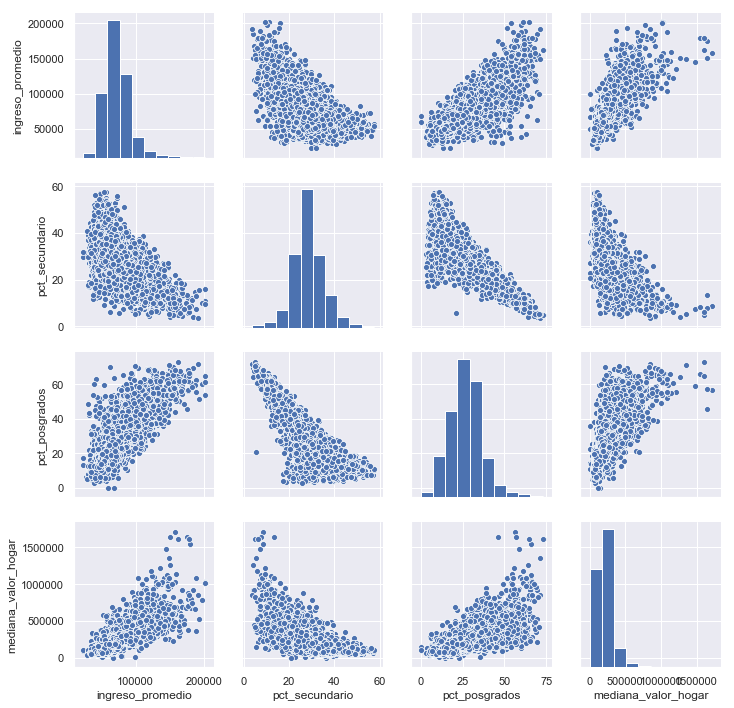

In [33]:
sns.pairplot(pos_df, vars=["ingreso_promedio", "pct_secundario", "pct_posgrados", "mediana_valor_hogar"])

Los resultados son los esperados:
*   A mayor ingreso, hogas más caros y más gente con posgrados (y menos con secundarios).


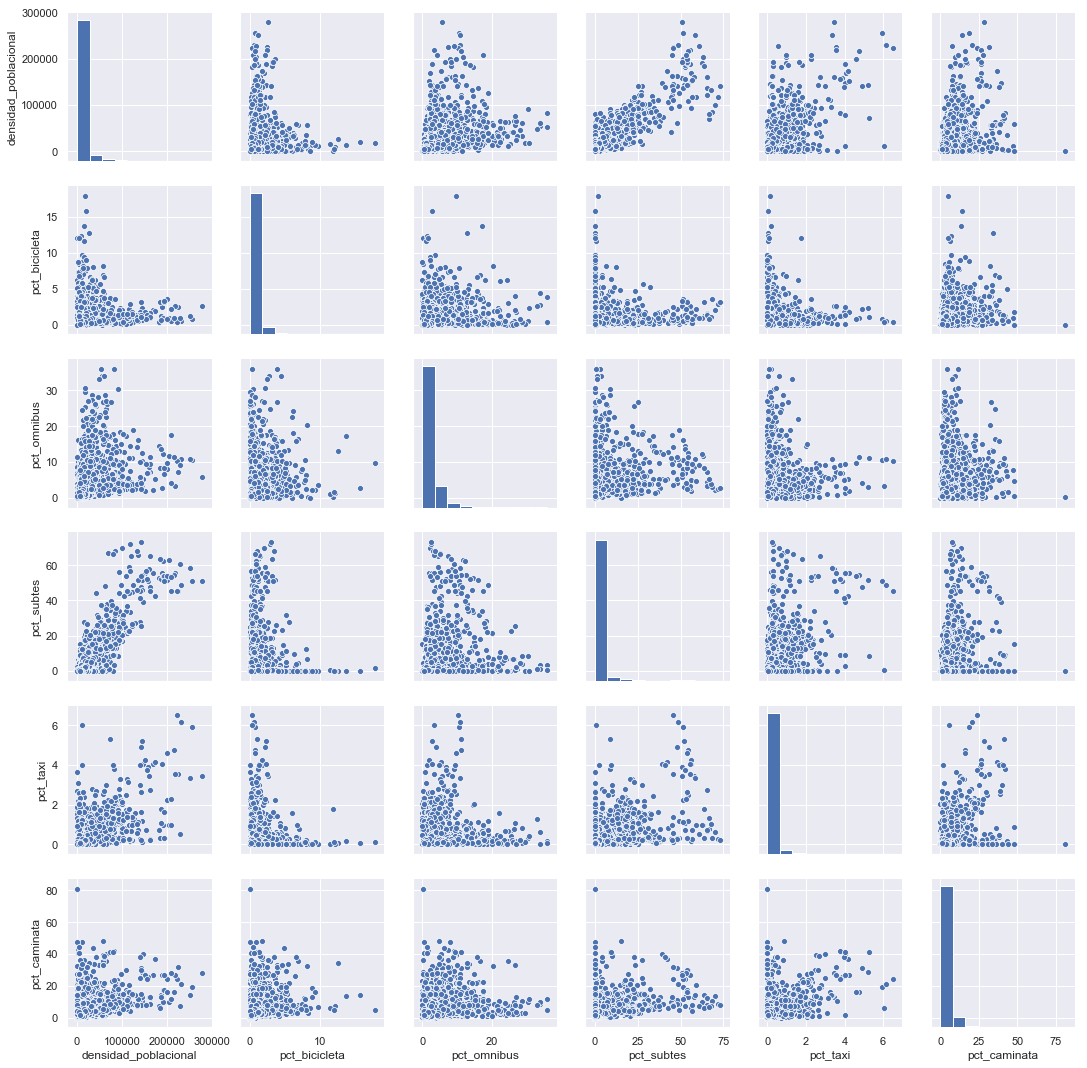

In [34]:
sns.pairplot(pos_df, vars=["densidad_poblacional", "pct_bicicleta", "pct_omnibus", "pct_subtes", "pct_taxi", "pct_caminata"])

### Nulos


#### Mediana
Podemos observar que aun quedan filas con campos en null.  Completamos cada columna con la mediana de la misma debido a que hay una posibilidad de que haya outliers

In [35]:
for col in pos_df.columns:
    pos_df[col] = pos_df[col].fillna((pos_df[col].median()))

display(pos_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12897 entries, 181 to 13077
Data columns (total 17 columns):
id_pos                  12897 non-null object
competidores            12897 non-null float64
ingreso_mediana         12897 non-null float64
ingreso_promedio        12897 non-null float64
densidad_poblacional    12897 non-null float64
pct_secundario          12897 non-null float64
pct_bicicleta           12897 non-null float64
pct_omnibus             12897 non-null float64
pct_subtes              12897 non-null float64
pct_taxi                12897 non-null float64
pct_caminata            12897 non-null float64
mediana_valor_hogar     12897 non-null float64
pct_ninios              12897 non-null float64
pct_jovenes             12897 non-null float64
pct_adultos             12897 non-null float64
pct_ancianos            12897 non-null float64
pct_posgrados           12897 non-null float64
dtypes: float64(16), object(1)
memory usage: 2.4+ MB


None

### Outliers
Graficamos boxplots en busqueda de outliers.

In [36]:
cols_outliers = pos_df.columns.tolist()
cols_outliers.remove("id_pos") # Graficamos todas las columnas menos 'id_pos'

<Figure size 1440x1440 with 0 Axes>

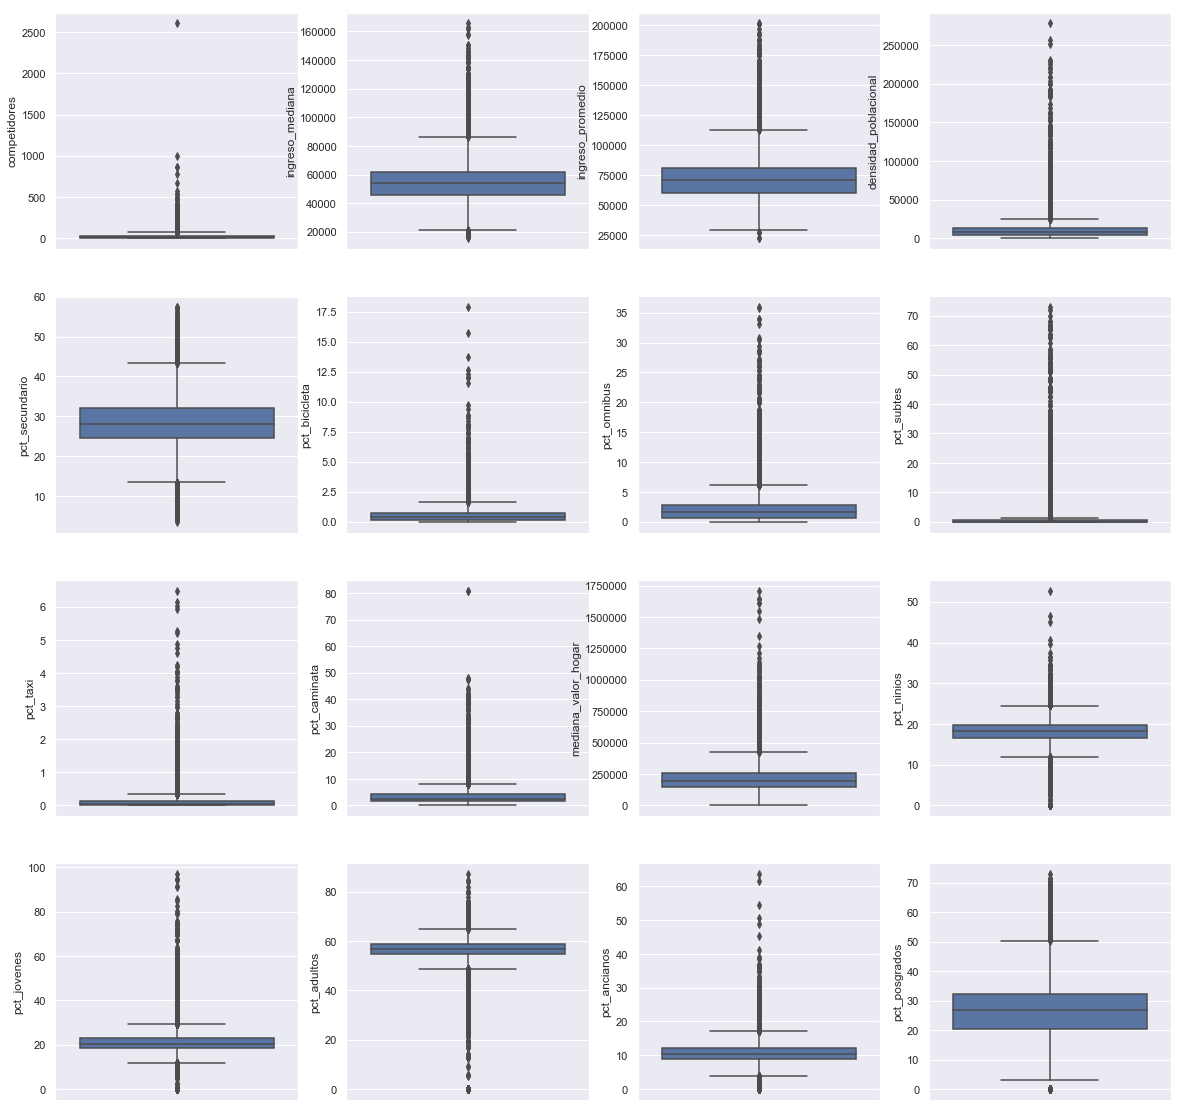

In [37]:
fig = plt.figure(figsize=(20,20))

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.ravel()

for i, col in enumerate(cols_outliers):
    sns.boxplot(pos_df[col], orient="v", ax=axs[i])

plt.show()

*   Como se puede observar, todo los atributos tienen outliers, y en algunos casos muy extremos.



Vamos a reemplazar los valores de los outliers por los extremos del *IQR*.

In [38]:
for i, col in enumerate(cols_outliers):
    q1, q3 = pos_df[col].quantile(.25), pos_df[col].quantile(.75)
    iqr = q3 - q1
    
    upper_limit = q3 + 3 * iqr
    lower_limit = q1 - 3 * iqr
    
    gt_max_filter = pos_df[col] > upper_limit  # Valores más grandes que el límite superior
    lt_min_filter = pos_df[col] < lower_limit  # Valores más chicos que el límite inferior
    
    pos_df.loc[gt_max_filter, col] = upper_limit
    pos_df.loc[lt_min_filter, col] = lower_limit

<Figure size 1440x1440 with 0 Axes>

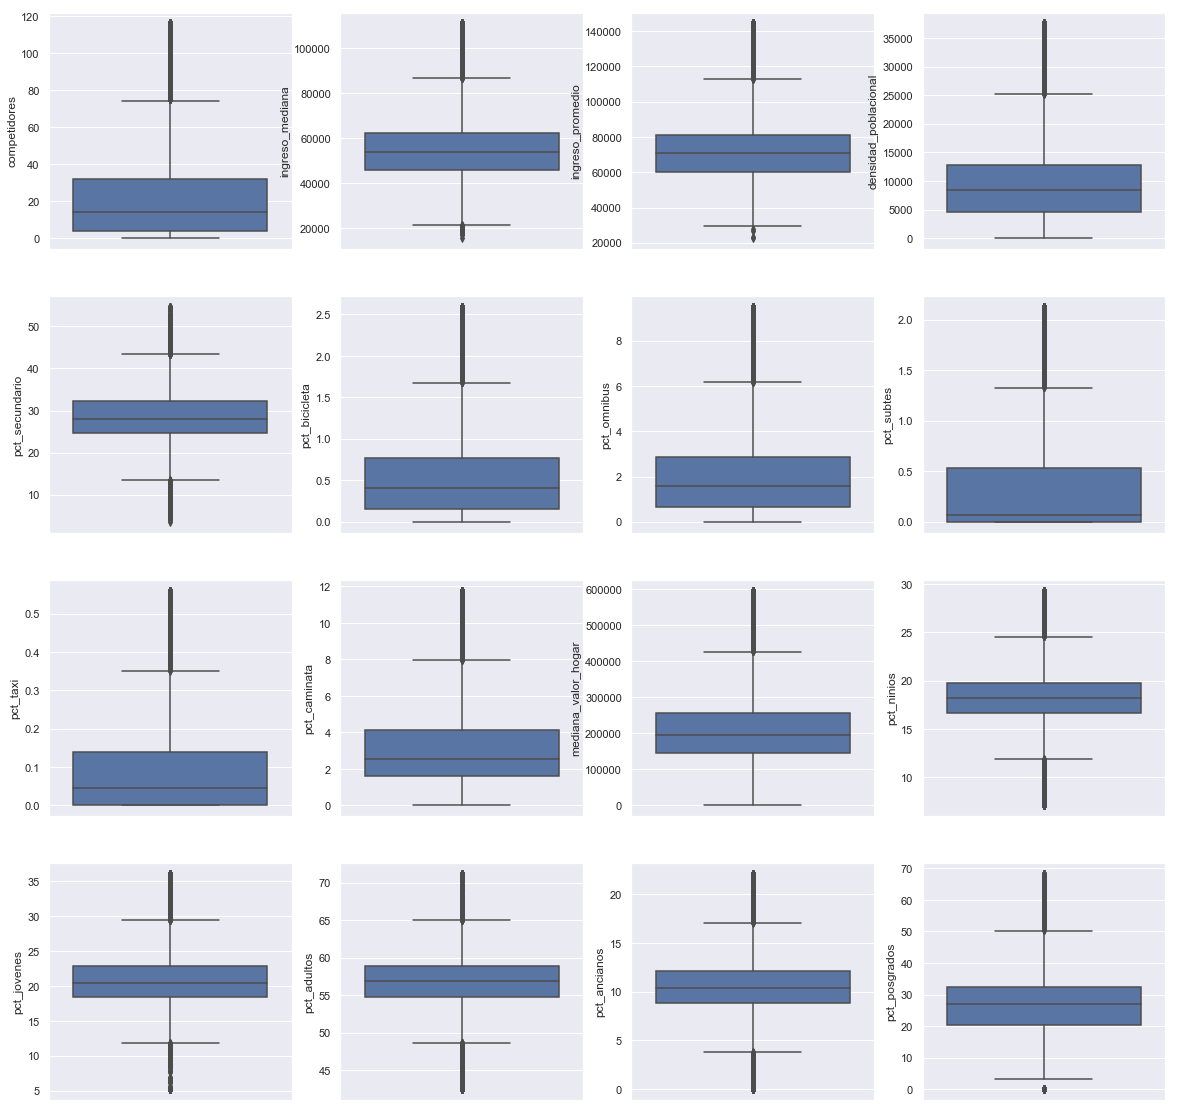

In [39]:
fig = plt.figure(figsize=(20,20))

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.ravel()

for i, col in enumerate(cols_outliers):
    sns.boxplot(pos_df[col], orient="v", ax=axs[i])

plt.show()

*  Se puede ver que ahora los atributos no tienen outliers extremos

## Merge - Ventas + Envíos


### Datos de envíos
Vamos a enriquecer el *dataset* de ventas con datos de los envíos:
*  *total_envios_recibidos*: Total de unidades recibidas por el POS hasta la fecha de la venta (en el mismo año)
*  *total_ventas*: Total de unidades vendidas por el POS hasta la fecha de la venta (en el mismo año)
*  *stock_restante*: Stock restante en el POS luego de la venta (*total_envios_recibidos* - *total_ventas*)

In [40]:
envios_df.set_index(["id_pos", "fecha_anio", "fecha"], inplace=True)
ventas_df.set_index(["id_pos", "fecha_anio", "fecha"], inplace=True)

envios_df.sort_index(inplace=True)
ventas_df.sort_index(inplace=True)

In [41]:
def get_total_envios(id_pos, fecha):
    """ Devuelve la cantidad de unidades recibidas por 'id_pos' hasta la fecha 'fecha' (en el mismo año) """
    try:
        envios_subset_df = envios_df.xs((id_pos, fecha.year), level=["id_pos", "fecha_anio"])
    except KeyError:
        return 0
    
    row_filter = envios_subset_df.index.get_level_values("fecha") <= fecha

    if sum(row_filter) > 0:
        return int(envios_subset_df.loc[row_filter]["unidades_despachadas"].sum())
    else:
        return 0


def get_total_ventas(id_pos, fecha):
    """ Devuelve la cantidad de unidades vendidas por 'id_pos' hast ala fecha 'fecha' (en el mismo año) """
    try:
        ventas_subset_df = ventas_df.xs((id_pos, fecha.year), level=["id_pos", "fecha_anio"])
    except KeyError:
        return 0
    
    row_filter = ventas_subset_df.index.get_level_values("fecha") <= fecha
  
    if sum(row_filter) > 0:
        return int(ventas_subset_df.loc[row_filter]["unidades"].sum())
    else:
        return 0

# ventas_df["total_envios_recibidos"] = ventas_df.apply(lambda row: get_total_envios(row.name[0], row.name[2]), 
#                                                       axis=1)
# ventas_df["total_ventas"] = ventas_df.apply(lambda row: get_total_ventas(row.name[0], row.name[2]), axis=1)
# ventas_df["stock_restante"] = ventas_df["total_envios_recibidos"] - ventas_df["total_ventas"]

In [42]:
ventas_df.reset_index(inplace=True)
envios_df.reset_index(inplace=True)

In [43]:
ventas_df.head(5)

,id_pos,fecha_anio,fecha,fecha_mes,fecha_dia,unidades,fecha_fin_de_semana,fecha_dia_trimestre,total_ventas_10_2012,total_ventas_11_2012,total_ventas_12_2012,total_ventas_10_2013,total_ventas_11_2013,total_ventas_12_2013,total_ventas_10_2014,total_ventas_11_2014,canal_ALMACEN,canal_MAXIKIOSCO,canal_PARTICULARES,canal_SUPERMERCADOS,fecha_dia_de_semana_domingo,fecha_dia_de_semana_jueves,fecha_dia_de_semana_lunes,fecha_dia_de_semana_martes,fecha_dia_de_semana_miercoles,fecha_dia_de_semana_sabado,fecha_dia_de_semana_viernes
0,10000,2012,2012-12-03,12,3,1,False,64,0.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0
1,10000,2012,2012-12-12,12,12,1,False,73,0.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0
2,10000,2012,2012-12-16,12,16,1,True,77,0.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0
3,10000,2012,2012-12-17,12,17,1,False,78,0.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0
4,10000,2012,2012-12-18,12,18,1,False,79,0.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0


## Merge - Ventas + Envíos + POS

### Join
Agregamos a *ventas_df* datos de *pos_df*

In [44]:
ventas_df = pd.merge(left=ventas_df, right=pos_df, how="left", on="id_pos")

display(ventas_df.shape)
display(ventas_df.head())

(266436, 43)

,id_pos,fecha_anio,fecha,fecha_mes,fecha_dia,unidades,fecha_fin_de_semana,fecha_dia_trimestre,total_ventas_10_2012,total_ventas_11_2012,total_ventas_12_2012,total_ventas_10_2013,total_ventas_11_2013,total_ventas_12_2013,total_ventas_10_2014,total_ventas_11_2014,canal_ALMACEN,canal_MAXIKIOSCO,canal_PARTICULARES,canal_SUPERMERCADOS,fecha_dia_de_semana_domingo,fecha_dia_de_semana_jueves,fecha_dia_de_semana_lunes,fecha_dia_de_semana_martes,fecha_dia_de_semana_miercoles,fecha_dia_de_semana_sabado,fecha_dia_de_semana_viernes,competidores,ingreso_mediana,ingreso_promedio,densidad_poblacional,pct_secundario,pct_bicicleta,pct_omnibus,pct_subtes,pct_taxi,pct_caminata,mediana_valor_hogar,pct_ninios,pct_jovenes,pct_adultos,pct_ancianos,pct_posgrados
0,10000,2012,2012-12-03,12,3,1,False,64,0.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,116.0,47365.62875,63786.27125,11176.98625,28.763333,0.915,2.937917,1.39125,0.10625,4.068333,260958.6958,15.201667,29.982917,52.427083,9.827083,27.146667
1,10000,2012,2012-12-12,12,12,1,False,73,0.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,1,0,0,0,0,0,0,0,1,0,0,116.0,47365.62875,63786.27125,11176.98625,28.763333,0.915,2.937917,1.39125,0.10625,4.068333,260958.6958,15.201667,29.982917,52.427083,9.827083,27.146667
2,10000,2012,2012-12-16,12,16,1,True,77,0.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,0,116.0,47365.62875,63786.27125,11176.98625,28.763333,0.915,2.937917,1.39125,0.10625,4.068333,260958.6958,15.201667,29.982917,52.427083,9.827083,27.146667
3,10000,2012,2012-12-17,12,17,1,False,78,0.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,116.0,47365.62875,63786.27125,11176.98625,28.763333,0.915,2.937917,1.39125,0.10625,4.068333,260958.6958,15.201667,29.982917,52.427083,9.827083,27.146667
4,10000,2012,2012-12-18,12,18,1,False,79,0.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,116.0,47365.62875,63786.27125,11176.98625,28.763333,0.915,2.937917,1.39125,0.10625,4.068333,260958.6958,15.201667,29.982917,52.427083,9.827083,27.146667


### Nulos

#### Mediana

In [45]:
for col in ventas_df.columns:
    if ventas_df[col].isna().sum() > 0:
        ventas_df[col] = ventas_df[col].fillna((ventas_df[col].median()))

display(ventas_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266436 entries, 0 to 266435
Data columns (total 43 columns):
id_pos                           266436 non-null object
fecha_anio                       266436 non-null int64
fecha                            266436 non-null datetime64[ns]
fecha_mes                        266436 non-null int64
fecha_dia                        266436 non-null int64
unidades                         266436 non-null int64
fecha_fin_de_semana              266436 non-null bool
fecha_dia_trimestre              266436 non-null int64
total_ventas_10_2012             266436 non-null float64
total_ventas_11_2012             266436 non-null float64
total_ventas_12_2012             266436 non-null float64
total_ventas_10_2013             266436 non-null float64
total_ventas_11_2013             266436 non-null float64
total_ventas_12_2013             266436 non-null float64
total_ventas_10_2014             266436 non-null float64
total_ventas_11_2014             266436 n

None

## Datos de salida
Exportamos los *DataFrames* preprocesados.

In [46]:
ventas_df.to_csv(os.path.join(data_path, "processed/ventas.csv"), index=False)
envios_df.to_csv(os.path.join(data_path, "processed/envios.csv"), index=False)
pos_df.to_csv(os.path.join(data_path, "processed/pos.csv"), index=False)